<a href="https://colab.research.google.com/github/AlexandreAdam/Censai/blob/eager2.4/notebooks/train_raytracer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RayTracer

Uncomment the following block to start

!git clone https://github.com/AlexandreAdam/Censai.git
%cd Censai
!git checkout eager2.4
!python setup.py install

# wanb login
%pip install wandb -q
%pip install tensorflow_addons
import wandb


In [1]:
import tensorflow as tf
from censai import RayTracer512 as RayTracer
from censai.data import NISGenerator
from datetime import datetime
import os
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow_addons as tfa
import numpy as np
# %matplotlib inline
# os.mkdir("logs") # run only once

In [2]:
def main(args):
#     if wndb:
#         config = wandb.config
#         config.learning_rate = args.lr
#         config.batch_size = args.batch_size
#         config.epochs = args.epochs
#         config.architecture="RayTracer UNET"
#         config.update(args)
    gen = NISGenerator(args.total_items, args.batch_size, pixels=args.pixels)
#     gen_test = NISGenerator(args.validation, args.validation, train=False, pixels=args.pixels)
    ray_tracer = RayTracer(
        initializer = args.initializer,
        bottleneck_kernel_size = args.bottleneck_kernel_size,
        bottleneck_strides = args.bottleneck_strides,
        pre_bottleneck_kernel_size = args.pre_bottleneck_kernel_size,
        decoder_encoder_kernel_size = args.decoder_encoder_kernel_size,
        decoder_encoder_filters = args.decoder_encoder_filters,
        upsampling_interpolation = args.upsampling_interpolation,  # use strided transposed convolution if false
        kernel_regularizer_amp = args.kernel_regularizer_amp,
        bias_regularizer_amp = args.bias_regularizer_amp,  # if bias is used
        kappalog = args.kappalog,
        normalize = args.normalize,
        use_bias = args.use_bias,
        activation=args.activation,
        filter_scaling=args.scaling,
    )
    optim = args.optimizer

    # setup tensorboard writer (nullwriter in case we do not want to sync)
    if args.logdir.lower() != "none":
        logdir = os.path.join(args.logdir, args.logname)
        traindir = os.path.join(logdir, "train")
        testdir = os.path.join(logdir, "test")
        if not os.path.isdir(logdir):
            os.mkdir(logdir)
        if not os.path.isdir(traindir):
            os.mkdir(traindir)
        if not os.path.isdir(testdir):
            os.mkdir(testdir)
        train_writer = tf.summary.create_file_writer(traindir)
        test_writer = tf.summary.create_file_writer(testdir)
    else:
        test_writer = nullwriter()
        train_writer = nullwriter()

    epoch_loss = tf.metrics.Mean()
    best_loss = np.inf
    patience = args.patience
    step = 1
    for epoch in range(1, args.epochs + 1):
        epoch_loss.reset_states()
        with train_writer.as_default():
            for batch, (kappa, alpha) in enumerate(gen):
        #========== Forward and backprop ==========
                with tf.GradientTape(watch_accessed_variables=True) as tape:
                    tape.watch(ray_tracer.trainable_weights)
#                     cost = ray_tracer.cost(link(kappa), alpha) # MSE loss function
                    cost = tf.reduce_mean(tf.square(ray_tracer(kappa) - alpha)) # also MSE
                    # Euclidian distance
#                     cost = tf.square(ray_tracer(link(kappa)) - alpha)
#                     cost = tf.reduce_mean(tf.sqrt(cost[..., 0] + cost[..., 1]))
                    cost += tf.reduce_sum(ray_tracer.losses) # add L2 regularizer loss
                gradient = tape.gradient(cost, ray_tracer.trainable_weights)
                if args.clipping:
                    clipped_gradient = [tf.clip_by_value(grad, -10, 10) for grad in gradient]
                else:
                    clipped_gradient = gradient
                optim.apply_gradients(zip(clipped_gradient, ray_tracer.trainable_variables)) # backprop

        #========== Summary and logs ==========
#                 print(ray_tracer.trainable_variables[-1][0])
                epoch_loss.update_state([cost])
                tf.summary.scalar("MSE", cost, step=step)
                step += 1
            # tf.summary.scalar("Learning Rate", optim.lr(step), step=step)
#         with test_writer.as_default():
#             for (kappa, alpha) in gen_test:
#                 test_cost = ray_tracer.cost(kappa, alpha)
#             tf.summary.scalar("MSE", test_cost, step=step)
        train_cost = epoch_loss.result().numpy()
        print(f"epoch {epoch} | train loss {train_cost:.3e} | learning rate {optim.lr(step).numpy():.2e}")
        if train_cost < best_loss - args.tolerance:
            best_loss = train_cost
            patience = args.patience
        else:
            patience -= 1
        if patience == 0:
            print("Reached patience")
            break

    return gen, ray_tracer, epoch_loss.result()

In [22]:
# quick hack to make a config like args of ArgumentParser
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

lr = 1e-4
decay_steps=50
decay_rate=0.95
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    lr,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True)
# init_range = 0.1
# initializer = tf.keras.initializers.RandomUniform(minval=-init_range, maxval=init_range)
# initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=0.001)
# initializer = tf.keras.initializers.GlorotNormal()
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999)
# opt = tf.keras.optimizers.RMSprop(learning_rate=lr_schedule, rho=0.9, momentum=0.1)
# opt = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0., nesterov=False)
# opt = tf.keras.optimizers.Adagrad(learning_rate=lr_schedule, initial_accumulator_value=0.1)

# setup hyperparameter and other configs
date = datetime.now().strftime("%y-%m-%d_%H-%M-%S")
Config = AttrDict()
Config.update({
    #hparams
    "initializer":"glorot_uniform",
    "bottleneck_kernel_size":16,
    "bottleneck_strides":4, # 4 -> bottleneck is 8 pixels, 2: 16 (kernel should then be 32 pixels)
    "pre_bottleneck_kernel_size":6,
    "decoder_encoder_kernel_size":3,
    "decoder_encoder_filters":32,
    "upsampling_interpolation":True,  # use strided transposed convolution if false
    "kernel_regularizer_amp":0,
    "bias_regularizer_amp":0,  # if bias is used
    "use_bias":False,
    "activation": "linear",
    "lr": lr, # initial learning rate
    "decay_steps": decay_steps,
    "decay_rate": decay_rate,
    "batch_size": 10,
    "kappalog": True,
    "normalize": False,
    "scaling": 2,
    "skip_connections": True,
    #training
    "epochs": 100,
    "clipping": False,
    "pixels": 512,
#     "initializer_type": "glorot_normal",
    "optimizer_name": "Adam",
    "total_items": 500, # items per epochs
    "logdir": "logs",
    "logname": date,
    "validation": 5,
    "patience": 10,
    "tolerance": 0,
    # "schedule": lr_schedule,
    "optimizer": opt,

})
tf.random.set_seed(None)


In [23]:
# wndb = True
# wandb.init(project="censai", entity="adam-alexandre01123", sync_tensorboard=True)
gen, ray_tracer, loss = main(Config)

epoch 1 | train loss 1.295e+00 | learning rate 9.50e-05
epoch 2 | train loss 3.302e-01 | learning rate 9.02e-05
epoch 3 | train loss 1.878e-01 | learning rate 8.57e-05
epoch 4 | train loss 1.290e-01 | learning rate 8.15e-05
epoch 5 | train loss 1.120e-01 | learning rate 7.74e-05
epoch 6 | train loss 1.117e-01 | learning rate 7.35e-05
epoch 9 | train loss 1.078e-01 | learning rate 6.30e-05
epoch 10 | train loss 7.316e-02 | learning rate 5.99e-05
epoch 11 | train loss 6.613e-02 | learning rate 5.69e-05
epoch 12 | train loss 7.259e-02 | learning rate 5.40e-05
epoch 13 | train loss 8.163e-02 | learning rate 5.13e-05
epoch 14 | train loss 5.834e-02 | learning rate 4.88e-05
epoch 15 | train loss 4.976e-02 | learning rate 4.63e-05
epoch 16 | train loss 5.480e-02 | learning rate 4.40e-05
epoch 17 | train loss 4.707e-02 | learning rate 4.18e-05
epoch 18 | train loss 4.625e-02 | learning rate 3.97e-05
epoch 19 | train loss 4.859e-02 | learning rate 3.77e-05
epoch 20 | train loss 4.679e-02 | lear

In [10]:
# from censai.definitions import conv2_layers_flops
# inputs = tf.keras.Input(shape=(512,512,1))
# ray_tracer.call(inputs)
# flops = 0
# for layer in ray_tracer.layers:
#     if "conv2d" in layer.name:
# #         print(layer.name)
#         flops += conv2_layers_flops(layer)
# flops/1e9

In [12]:
# ray_tracer.estimate_flops(input_shape=[512, 512, 1]) / 1e9

In [12]:
# Vanilla convolution Flops
2 * 512**2 * 1024**2 / 1e9

549.755813888

In [22]:
# FFT convolution flops
2 * (2 * 1024 + 1)**2 * np.log(2 * 1024) ** 2 / 1e9

0.4881465282091002

In [27]:
# minimum memory requirement of fft conv
4 * (2 * 1024 + 1)**2 * 32 / 1e9

0.537395328

In [15]:
# ray_tracer.summary()

In [16]:
# memory requirement of ray tracer
1877344 * 32 / 1e9

0.060075008

In [13]:
kap, alp = gen[0]

In [14]:
alpha_pred = ray_tracer(kap)

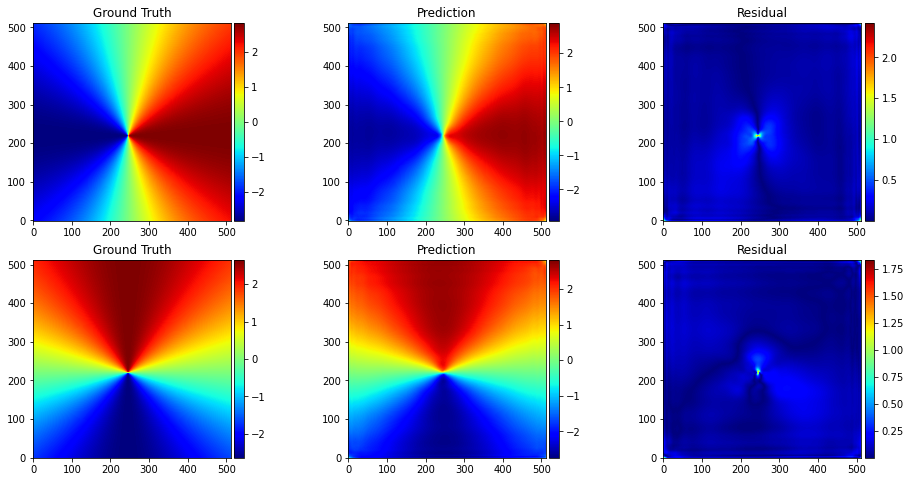

In [19]:
ind = 4
dim = 1

fig, axs = plt.subplots(2, 3, figsize=(16, 8))
for i in range(2):
    im = axs[i, 0].imshow(alp.numpy()[ind, ..., i], cmap="jet", origin="lower")
    divider = make_axes_locatable(axs[i, 0])
    cax    = divider.append_axes("right", size="5%", pad=0.05) 
    plt.colorbar(im,cax=cax)   
    axs[i, 0].set_title("Ground Truth")

    im = axs[i, 1].imshow(alpha_pred.numpy()[ind, ..., i], cmap="jet", origin="lower")
    divider = make_axes_locatable(axs[i, 1])
    cax    = divider.append_axes("right", size="5%", pad=0.05) 
    plt.colorbar(im,cax=cax)   
    axs[i, 1].set_title("Prediction")


    residual = np.abs(alpha_pred.numpy()[ind, ..., i] - alp.numpy()[ind, ..., i])
#     residual = np.abs(alpha_pred.numpy()[ind, ..., i] - link(kap[ind, ..., 0]))
    im = axs[i, 2].imshow(residual, cmap="jet", origin="lower")
    divider = make_axes_locatable(axs[i, 2])
    cax    = divider.append_axes("right", size="5%", pad=0.05) 
    plt.colorbar(im,cax=cax)
    axs[i, 2].set_title("Residual")

In [9]:
# ray_tracer.cost(link(kap), alp)

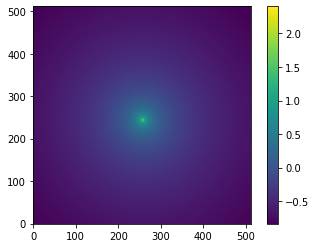

In [16]:
plt.imshow(link(kap[ind, ..., 0]), origin="lower")
plt.colorbar()

In [18]:
# plt.figure(figsize=(6, 6))
# plt.imshow(np.log(gen.kappa_field(xlens=0, ylens=0, elp=0.1, phi=0, r_ein=1)[..., 0])/np.log(10))
# plt.contour(np.log(gen.kappa_field(xlens=0, ylens=0, elp=0.1, phi=0, r_ein=1)[..., 0])/np.log(10))
# plt.colorbar()

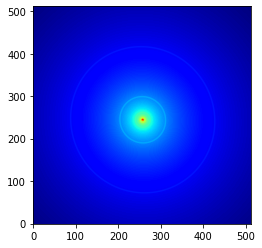

In [19]:
plt.imshow(link(kap.numpy()[ind, ..., 0]), cmap="jet", origin="lower")
plt.contour(link(kap.numpy()[ind, ..., 0]), cmap="jet", origin="lower")
# plt.colorbar();

In [20]:
kap.numpy().min()

0.08519043

In [21]:
from censai.data_generator import Generator
args = Config
gen = NISGenerator(args.total_items, args.batch_size, pixels=args.pixels)
gen_true = Generator(args.total_items, args.batch_size, src_side_pixels=args.pixels)

In [22]:
kap, alp = gen[0]

In [23]:
def get_deflection_angles(kappa, kap_side=7.68, kap_numpix=512, numpix_side=512, im_side=7.68):
    kap_side = kap_side
    kernel_side_l = kap_numpix*2+1;
    cond = np.zeros((kernel_side_l, kernel_side_l))
    cond[kap_numpix, kap_numpix] = True
    dx_kap = kap_side/(kap_numpix-1)
    x = tf.linspace(-1., 1., kernel_side_l)*kap_side
    y = tf.linspace(-1., 1., kernel_side_l)*kap_side
    X_filt, Y_filt = tf.meshgrid(x, y)
    kernel_denom = tf.square(X_filt) + tf.square(Y_filt)
    Xconv_kernel = tf.divide(-X_filt , kernel_denom)
    B = tf.zeros_like(Xconv_kernel)
    Xconv_kernel = tf.where(cond, B, Xconv_kernel)
    Yconv_kernel = tf.divide(-Y_filt , kernel_denom)
    Yconv_kernel = tf.where(cond, B, Yconv_kernel)
    Xconv_kernel = tf.reshape(Xconv_kernel, [kernel_side_l, kernel_side_l, 1,1])
    Yconv_kernel = tf.reshape(Yconv_kernel, [kernel_side_l, kernel_side_l, 1,1])
    x = tf.linspace(-1., 1., numpix_side)*im_side/2.
    y = tf.linspace(-1., 1., numpix_side)*im_side/2.
    Xim, Yim = tf.meshgrid(x, y)
    Xim = tf.reshape(Xim, [-1, numpix_side, numpix_side, 1])
    Yim = tf.reshape(Yim, [-1, numpix_side, numpix_side, 1])

    alpha_x = tf.nn.conv2d(kappa, Xconv_kernel, [1, 1, 1, 1], "SAME") * (dx_kap**2/np.pi);
    alpha_y = tf.nn.conv2d(kappa, Yconv_kernel, [1, 1, 1, 1], "SAME") * (dx_kap**2/np.pi);
    Xsrc = tf.add(tf.reshape(Xim, [-1, numpix_side, numpix_side, 1]),  - alpha_x )
    Ysrc = tf.add(tf.reshape(Yim, [-1, numpix_side, numpix_side, 1]),  - alpha_y )
    return alpha_x, alpha_y

def lens_source(kappa, source, r_ein, e, phi, x0, y0):
    src_side = 3.
    kap_side=7.68
    pixels=512
    x = tf.linspace(-1, 1, pixels)
    x = tf.cast(x, tf.float32)
    x_source, y_source = [xx * src_side/2 for xx in tf.meshgrid(x, x)]
    theta1, theta2 = [xx * kap_side/2 for xx in tf.meshgrid(x, x)]
    theta1 = theta1
    theta2 = theta2

    alpha_x, alpha_y = get_deflection_angles(kappa)
    beta1 = theta1[tf.newaxis, ..., tf.newaxis] - alpha_x  # lens equation
    beta2 = theta2[tf.newaxis, ..., tf.newaxis] - alpha_y
    dx = src_side/(pixels - 1)
    xmin = -0.5 * src_side
    ymin = -0.5 * src_side
    i_coord = (beta1 - xmin) / dx
    j_coord = (beta2 - ymin) / dx
    wrap = tf.concat([i_coord, j_coord], axis=-1)
    im = tfa.image.resampler(source, wrap) # bilinear interpolation
    return im


In [231]:
ax, ay = get_deflection_angles(kap)

Text(0.5, 1.0, 'Analytic y')

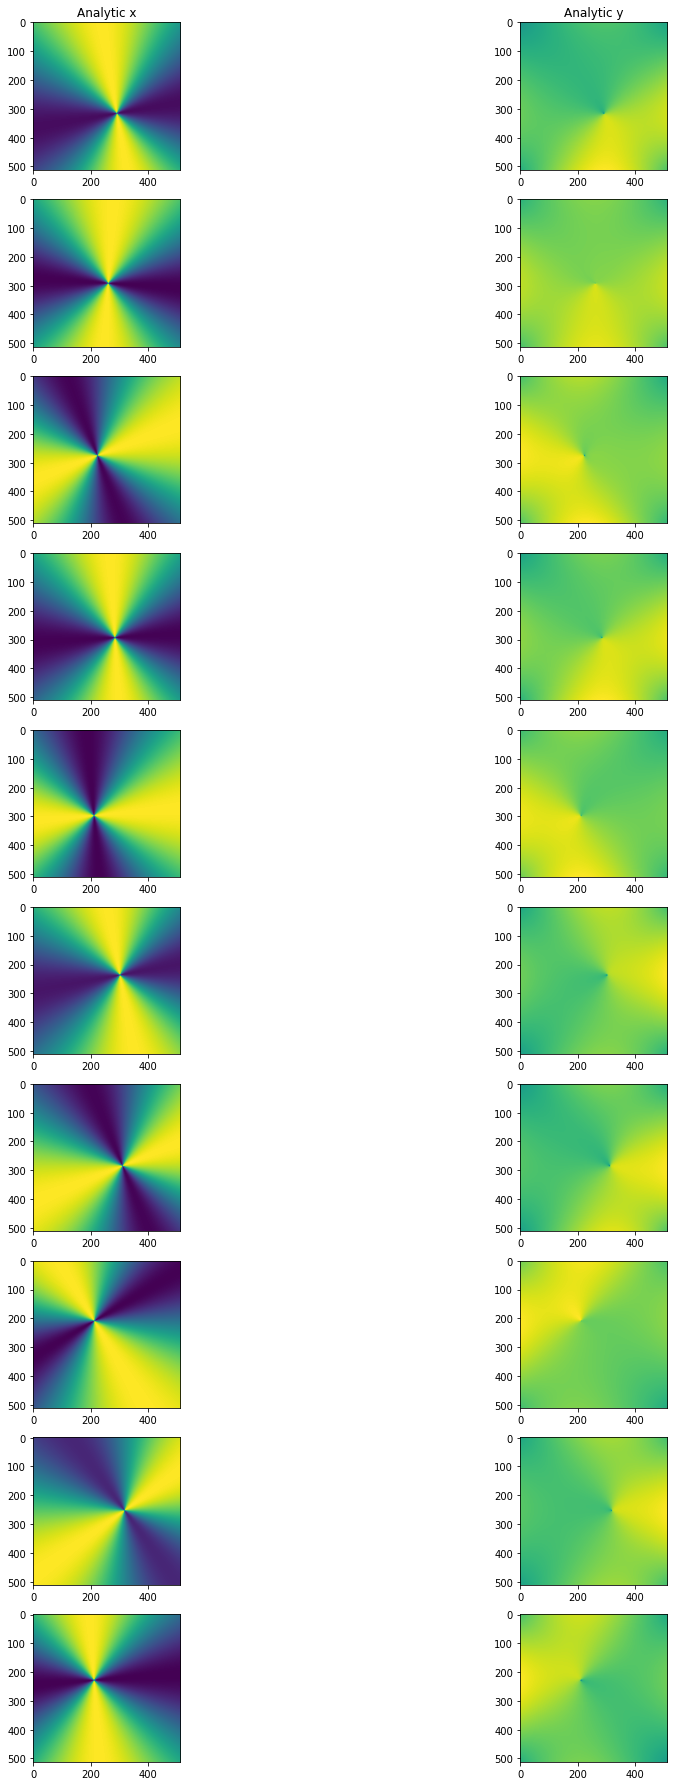

In [232]:
fig, axs = plt.subplots(10, 2, figsize=(16, 32))
for i in range(10):
    axs[i, 0].imshow(np.sqrt(alp[i, ..., 0]**2 + alp[i, ..., 1]**2))
#     axs[i, 0].imshow(alp[i, ..., 0])
#     axs[i, 0].axis("off")
#     axs[i, 1].imshow(alp[i, ..., 1])
#     axs[i, 1].axis("off")
    axs[i, 1].imshow(np.sqrt(ax[i, ...]**2 + ay[i, ...]**2))
#     axs[i, 2].imshow(ax[i, ...])
#     axs[i, 2].axis("off")
#     axs[i, 3].imshow(ay[i, ...])
#     axs[i, 3].axis("off")
axs[0, 0].set_title("Analytic x")
axs[0, 1].set_title("Analytic y")
# axs[0, 2].set_title("Convolution x")
# axs[0, 3].set_title("Convolution y")

In [233]:
np.sqrt(alp[i, ..., 0]**2 + alp[i, ..., 1]**2).min()

1.2164938

In [234]:
np.sqrt(alp[i, ..., 0]**2 + alp[i, ..., 1]**2).max()

1.3443428

In [235]:
np.sqrt(ax[i, ...]**2 + ay[i, ...]**2).min()

0.4466845

In [236]:
np.sqrt(ax[i, ...]**2 + ay[i, ...]**2).max()

1.4632088

In [35]:
dtype = tf.float32
xlens = tf.constant(0, dtype=dtype)[tf.newaxis, tf.newaxis, tf.newaxis]
ylens = tf.constant(0, dtype=dtype)[tf.newaxis, tf.newaxis, tf.newaxis]
elp   = tf.constant(0.1, dtype=dtype)[tf.newaxis, tf.newaxis, tf.newaxis]
phi   = tf.constant(np.pi/4, dtype=dtype)[tf.newaxis, tf.newaxis, tf.newaxis]
r_ein = tf.constant(1.,dtype=dtype)[tf.newaxis, tf.newaxis, tf.newaxis]

xs    = tf.constant(0, dtype=dtype)[tf.newaxis, tf.newaxis, tf.newaxis]
ys    = tf.constant(0, dtype=dtype)[tf.newaxis, tf.newaxis, tf.newaxis]
e     = tf.constant(0, dtype=dtype)[tf.newaxis, tf.newaxis, tf.newaxis]
phi_s = tf.constant(0, dtype=dtype)[tf.newaxis, tf.newaxis, tf.newaxis]
w     = tf.constant(0.05, dtype=dtype)[tf.newaxis, tf.newaxis, tf.newaxis]
# ylens = tf.random.uniform(shape=[1, 1, 1], minval=-.5, maxval=.5)
# elp   = tf.random.uniform(shape=[1, 1, 1], minval=0., maxval=0.2)
# phi   = tf.random.uniform(shape=[1, 1, 1], minval=-pi, maxval=pi)
# r_ein = tf.random.uniform(shape=[1, 1, 1], minval=1, maxval=2.)

# xs    = tf.random.uniform(shape=[1, 1, 1], minval=-0.1, maxval=0.1)
# ys    = tf.random.uniform(shape=[1, 1, 1], minval=-0.1, maxval=0.1)
# e     = tf.random.uniform(shape=[1, 1, 1], minval=0, maxval=0.3)
# phi_s = tf.random.uniform(shape=[1, 1, 1], minval=-pi, maxval=pi)
# w     = tf.random.uniform(shape=[1, 1, 1], minval=0.1, maxval=0.2)

kappa = gen.kappa_field(xlens, ylens, elp, phi, r_ein)
source = gen.source_model(xs, ys, e, phi_s, w)
lensed_image = gen.lens_source(source, r_ein, elp, phi, xlens, ylens)


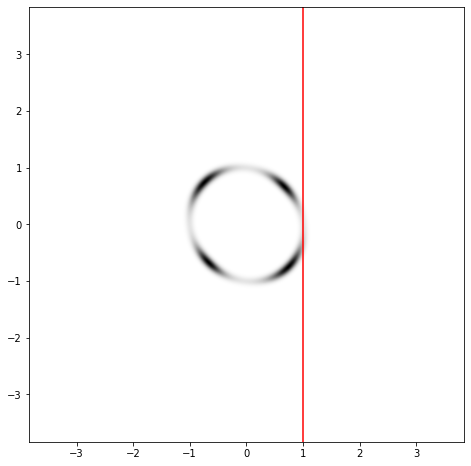

In [36]:
plt.figure(figsize=(8, 8))
plt.imshow(lensed_image[0, ..., 0], extent=[-7.68/2, 7.68/2]*2, cmap="gray_r")
plt.axvline(r_ein, color="r")

In [37]:
lens_conv = lens_source(kappa, source, r_ein, e, phi, xs, ys)

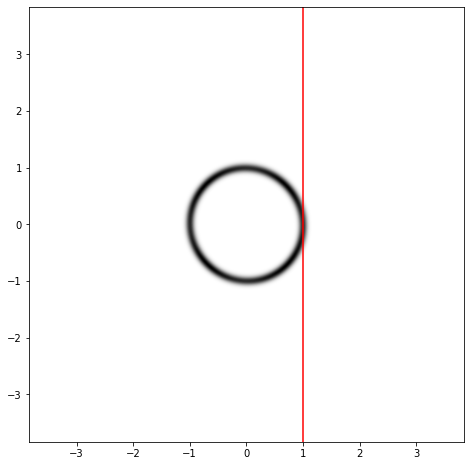

In [38]:
plt.figure(figsize=(8, 8))
plt.imshow(lens_conv[0, ..., 0], extent=[-7.68/2, 7.68/2]*2, cmap="gray_r")
plt.axvline(r_ein, color="r")